## Globals

In [8]:
import matplotlib
matplotlib.use('agg')
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import numpy as np
import seaborn as sns
import pyfaidx
sns.set_style('ticks')
sns.set_context('paper')

matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('font', size=8)
matplotlib.rc('xtick', labelsize=6)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=6)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=9)
matplotlib.rc('axes', linewidth=.6)
matplotlib.rc('xtick.major', width=.6)
matplotlib.rc('xtick.major', size=2.5)
matplotlib.rc('ytick.major', width=.6)
matplotlib.rc('ytick.major', size=2.5)

flu_gtf_file = "../data/genomes/influenza/lowctgnp_wsn_pr8.gtf.tsv"
flu_fasta_file = "../data/genomes/influenza/lowctgnp_wsn_pr8.fasta"


## Read in NP alignment files

In [6]:
### read in NP alignment files
vir_samples=['cyclo_vir','cyclo_ifn_vir','ltm_vir','ltm_ifn_vir']

directory='/fh/fast/subramaniam_a/user/rasi/analysis/riboseq/20180329_heather_a549_wsn_ifn_ltm_r2/processeddata/'
data=[]
for sample in vir_samples:
    np_align=pd.read_csv('%s%s/np_alignments.tsv'%(directory,sample),sep='\t')
    np_align['sample']=sample
    data.append(np_align)
np_align=pd.concat(data)


## Convert to CDS coordinates and trim to P-site

In [23]:
# NP start site from GTF file
flu_gtf = pd.read_csv(
    flu_gtf_file, 
    sep='\t', 
    header=None,
    names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
flu_gtf = flu_gtf[flu_gtf['source'].notnull()]
start=flu_gtf.query('seqid=="NP" & type == "start_codon"').start.values[0]  ### this is based on 1 numbering


# convert to 1 numbering and cds numbering (this is assuming input NP file is in 1 numbering)
np_align['start']=np_align['start']+1-start
np_align['end']=np_align['end']+1-start

#calculate read length (this is assuming that the end value is not inclusive - makefile allows reads from 25- 40 nucleotides
#but when I don't add 1 to read length I get read lengths that are 24-29 nt)
np_align['alignment length']=np_align['end']-np_align['start']+1 

# determine 13 or 14 nucleotide trim to p-site based on read length (14 nt for reads greater than 32, 13 nt for less than 33 nt
## these trimming parameters produce data with local peak at 322
np_align['trim paramter']=np.where(np_align['alignment length']>=33, 14, 13)
np_align['psite_position']=np_align['start']+np_align['trim paramter']



## Make histogram of read 3' end for reads with p-site at position 322 for highCTG NP reads

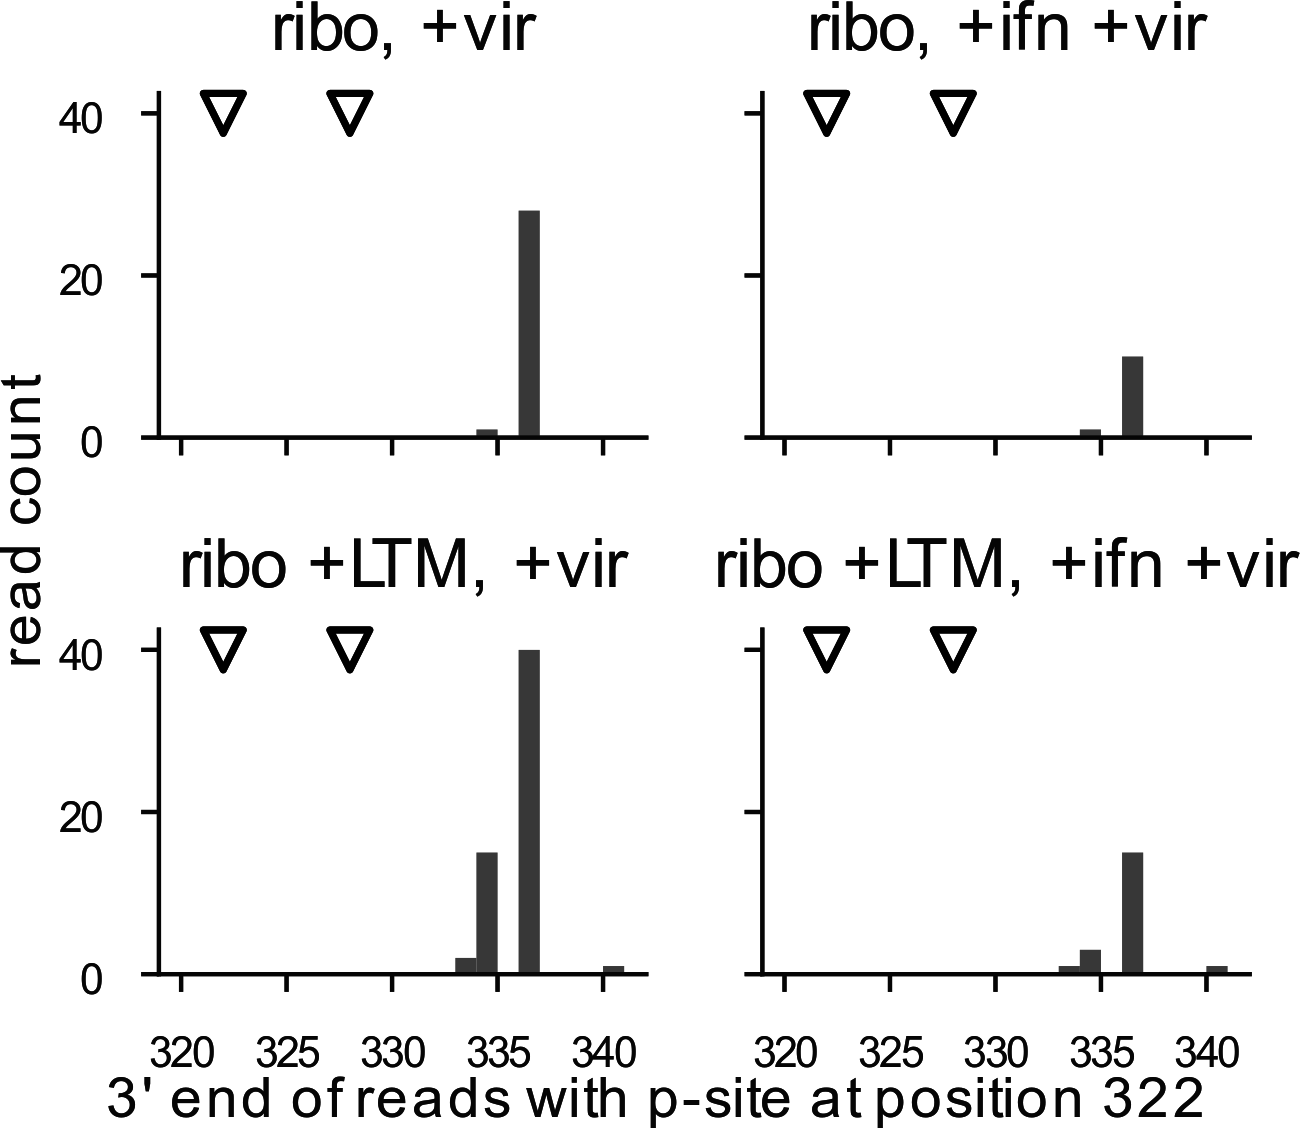

In [25]:
#subset site 322 to plot read 3' end
sub=np_align.query('seqname == "NPhighCTG" & psite_position ==322')

#plot
plot_order=vir_samples
plot_titles=['ribo, +vir','ribo, +ifn +vir','ribo +LTM, +vir','ribo +LTM, +ifn +vir']
fig, ax = matplotlib.pyplot.subplots()
g = sns.FacetGrid(sub, col="sample", col_wrap=2,col_order=plot_order,margin_titles=True)
bins = np.linspace(320, 341, 22)
g.map(plt.hist, "end", bins=bins, lw=0,color="grey")
g.fig.text(0.02, 0.5, 'read count', va='center', rotation='vertical')
g.fig.text(0.1, 0.04, "3' end of reads with p-site at position 322", va='center', rotation='horizontal')
g.set_xlabels('').set_titles('').set(xticks=[320,325, 330,335, 340])
c=0
for axax in g.axes.ravel():
    axax.set_title(plot_titles[c])
    c+=1
    axax.scatter([322,328], [40,40],marker='v', color='white',edgecolors='black',linewidths=1)    
    
g.fig.set_size_inches(2.7,2.4)
g.fig.tight_layout(pad=1.5)
filepath = '../figures/NP_322_readend_histogram.svg' 
plt.savefig(filepath)
png = filepath.rstrip('.svg') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=250))
sys.stdout.flush()

## make histogram of read lengths for all NP reads and for high CTG NP reads with p-site at 322 

In [26]:
flu_genome = pyfaidx.Fasta(flu_fasta_file)
snp_list=[]
for index,base in enumerate(str(flu_genome['NPlowCTG'])):
    if base != str(flu_genome['NPhighCTG'][index]):
        #convert to CDS: subtract start (which is in cds coord), add 2
        snp_cds=index - NPstart + 2
        snp_list.append(snp_cds)
low_snp=[]
for sample in vir_samples:
    sample_low_reads=[]
    for snp in snp_list:
        sub_low=np_align.query('sample ==@sample & seqname == "NPlowCTG" & start <=@snp & end >=@snp')
        sample_low_reads.append(sub_low)
    sample_lowdf=pd.concat(sample_low_reads)
    sample_lowdf=sample_lowdf.drop_duplicates()
    low_snp.append(sample_lowdf)
sub_low=pd.concat(low_snp)
sub_high=np_align.query(' seqname == "NPhighCTG"')
all_np=pd.concat([sub_high,sub_low])
sub=np_align.query('seqname == "NPhighCTG" & psite_position ==322')
df = pd.merge(np_align, sub, on=['names','sample','seqname','start','end','alignment length','trim paramter','psite_position'], how='left', indicator='Exist')
#df.drop('Rating', inplace=True, axis=1)
df['Exist'] = np.where(df.Exist == 'both', True, False)



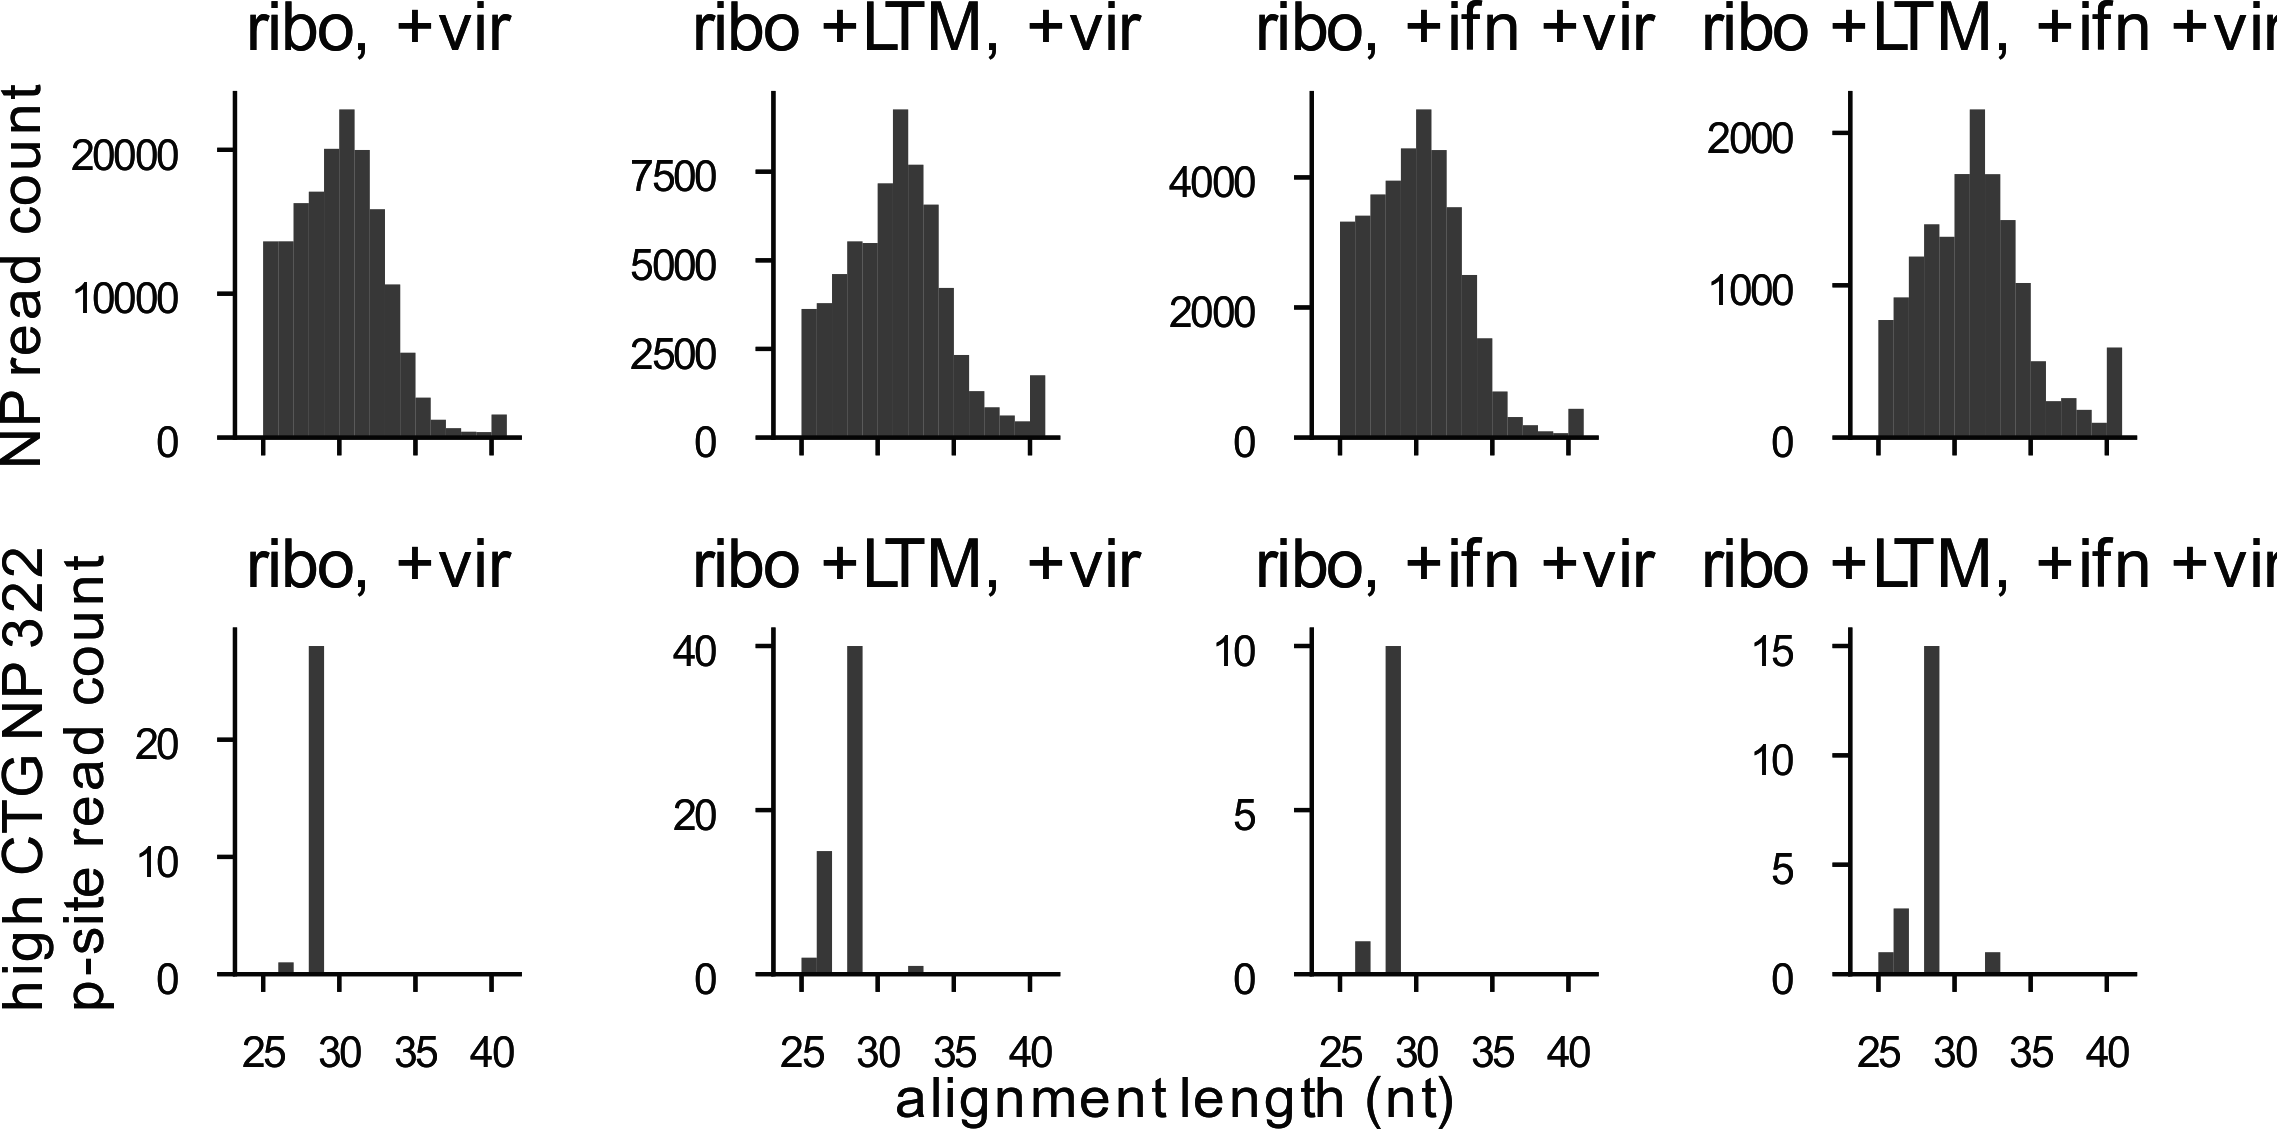

In [27]:
plot_order=['cyclo_vir','ltm_vir','cyclo_ifn_vir','ltm_ifn_vir']
plot_titles=['ribo, +vir','ribo +LTM, +vir','ribo, +ifn +vir','ribo +LTM, +ifn +vir']
fig, ax = matplotlib.pyplot.subplots()
g = sns.FacetGrid(df, col="sample", row='Exist',col_order=plot_order,margin_titles=False,sharey=False)
bins = np.linspace(24, 41, 18)

g.map(plt.hist, "alignment length", color="gray", bins=bins, lw=0)

g.set_xlabels('').set_titles('').set(xticks=[25, 30,35, 40])
c=0
for axax in g.axes.ravel():
    axax.set_title(plot_titles[c])
    c+=1
    if c==4:
        c=0
g.fig.text(0.01, 0.7, 'NP read count', va='center', rotation='vertical')
g.fig.text(0.01, 0.3, 'high CTG NP 322 \np-site read count', va='center', rotation='vertical')
g.fig.text(0.4, 0.04, 'alignment length (nt)', va='center', rotation='horizontal')


g.fig.set_size_inches(4.5,2.4)
g.fig.tight_layout(pad=1.5)
filepath = '../figures/NP_readlength_histogram.svg' 
plt.savefig(filepath)
png = filepath.rstrip('.svg') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))
sys.stdout.flush()